In [97]:
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
import pandas as pd
import requests
from io import StringIO
from sklearn.preprocessing import MinMaxScaler

In [32]:
with open('/Users/marcgrayson/Downloads/alphavantage_API.rtf', 'r') as file:
    api_key = file.read().strip()

In [48]:
url = 'https://www.alphavantage.co/query'
parametros = {
    'function': 'TIME_SERIES_DAILY_ADJUSTED',
    'symbol': 'NVDA',
    'outputsize': 'full', # historical data 
    'datatype': 'csv',
    'apikey': api_key
}

r = requests.get(url, params=parametros)
df = pd.read_csv(StringIO(r.text))

print(df.head())

    timestamp    open    high       low   close  adjusted_close    volume  \
0  2023-06-02  400.97  405.00  390.5801  393.27          393.27  48273121   
1  2023-06-01  384.89  400.50  383.4000  397.70          397.70  63587295   
2  2023-05-31  394.88  402.95  378.2200  378.34          378.34  99882681   
3  2023-05-30  405.95  419.38  399.4900  401.11          401.11  92340110   
4  2023-05-26  378.90  391.70  375.5000  389.46          389.46  71439676   

   dividend_amount  split_coefficient  
0              0.0                1.0  
1              0.0                1.0  
2              0.0                1.0  
3              0.0                1.0  
4              0.0                1.0  


In [79]:
df = df[['timestamp', 'open']]
df = df.sort_values('timestamp')

In [80]:
print(df)

       timestamp    open
5934  1999-11-01   21.75
5933  1999-11-02   23.94
5932  1999-11-03   26.00
5931  1999-11-04   27.75
5930  1999-11-05   30.00
...          ...     ...
4     2023-05-26  378.90
3     2023-05-30  405.95
2     2023-05-31  394.88
1     2023-06-01  384.89
0     2023-06-02  400.97

[5935 rows x 2 columns]


In [85]:
def DescomponerSerie(serie, longitud):
    X, y = list(), list()
    for i in range(len(serie)):
        final = i + longitud
        if final > len(serie) - 1:
            break
        historia_x, target_y = serie[i:final], serie[final]
        X.append(historia_x)
        y.append(target_y)
    return np.array(X), np.array(y)

In [86]:
SecuenciaStock = list(df["open"])

In [99]:
SecuenciaStock = df["open"].values.reshape(-1, 1)

# Normalizar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
SecuenciaStock = scaler.fit_transform(SecuenciaStock)

In [100]:
X, y = DescomponerSerie(SecuenciaStock, 3)
print("X:", X)
print("y:", y)

X: [[[0.01901852]
  [0.021663  ]
  [0.02415051]]

 [[0.021663  ]
  [0.02415051]
  [0.02626368]]

 [[0.02415051]
  [0.02626368]
  [0.02898061]]

 ...

 [[0.45792982]
  [0.45028618]
  [0.48294974]]

 [[0.45028618]
  [0.48294974]
  [0.46958244]]

 [[0.48294974]
  [0.46958244]
  [0.45751926]]]
y: [[0.02626368]
 [0.02898061]
 [0.02581689]
 ...
 [0.46958244]
 [0.45751926]
 [0.47693627]]


In [170]:
model = Sequential()
model.add(Dense(5, activation='relu', input_dim=3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


In [171]:
model.fit(X, y, epochs=50, batch_size=50)

Epoch 1/50
119/119 [==============================] - 0s 303us/step - loss: 0.0045
Epoch 2/50
119/119 [==============================] - 0s 295us/step - loss: 6.8292e-04
Epoch 3/50
119/119 [==============================] - 0s 300us/step - loss: 2.2090e-04
Epoch 4/50
119/119 [==============================] - 0s 297us/step - loss: 1.7630e-04
Epoch 5/50
119/119 [==============================] - 0s 299us/step - loss: 1.6790e-04
Epoch 6/50
119/119 [==============================] - 0s 297us/step - loss: 1.6288e-04
Epoch 7/50
119/119 [==============================] - 0s 296us/step - loss: 1.5863e-04
Epoch 8/50
119/119 [==============================] - 0s 292us/step - loss: 1.5854e-04
Epoch 9/50
119/119 [==============================] - 0s 289us/step - loss: 1.5396e-04
Epoch 10/50
119/119 [==============================] - 0s 283us/step - loss: 1.5436e-04
Epoch 11/50
119/119 [==============================] - 0s 288us/step - loss: 1.5313e-04
Epoch 12/50
119/119 [========================

In [168]:
# Obtener las últimas 3 observaciones de los datos originales para hacer la primera predicción
input_data = SecuenciaStock[-3:]

predictions = []

# Hacer 12 predicciones
for _ in range(12):
    prediction = model.predict(input_data.reshape(1, -1))
    predictions.append(prediction[0, 0])

    # Actualizar los datos de entrada para incluir la nueva predicción y excluir el valor más antiguo
    input_data = np.append(input_data[1:], prediction)

# Desnormalizar las predicciones
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

print("predictions:", predictions)


1/1 [==============================] - 0s 7ms/step
predictions: [[395.4152 ]
 [393.36624]
 [397.22845]
 [396.17963]
 [395.93002]
 [397.02115]
 [396.99777]
 [397.157  ]
 [397.62067]
 [397.83182]
 [398.08505]
 [398.40778]]


1/1 [==============================] - 0s 12ms/step


/var/folders/h9/4sh2_tlj0m7d6g2nzdl9fs_w0000gn/T/ipykernel_21220/1875901436.py:27: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(pd.to_datetime(df['timestamp'][:20]), df['open'][:20], label='Original data')
/var/folders/h9/4sh2_tlj0m7d6g2nzdl9fs_w0000gn/T/ipykernel_21220/1875901436.py:27: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(pd.to_datetime(df['timestamp'][:20]), df['open'][:20], label='Original data')


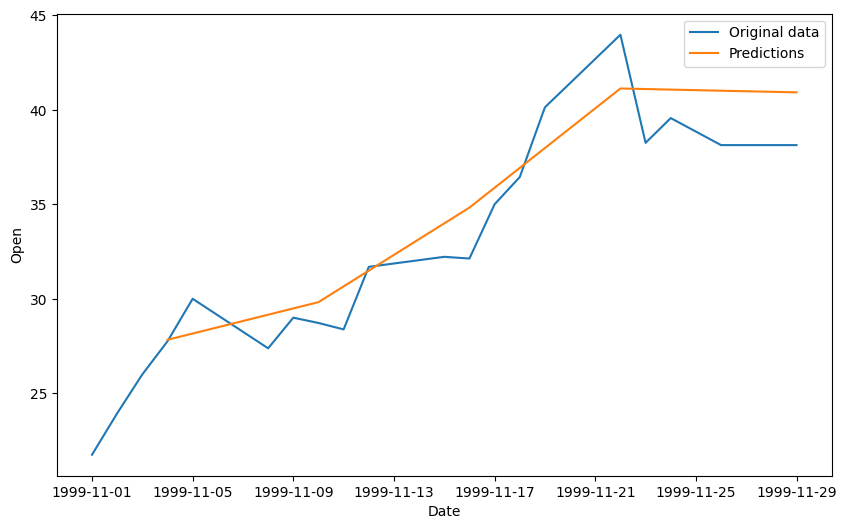

In [181]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming model is already defined and trained
inputs = [X[i:i+1].reshape(1, -1) for i in range(0, 20, 4)]

predictions = []

for input in inputs:
    pred = model.predict(input)
    predictions.append(pred[0])

# Apply inverse transformation to predictions
predictions_inv = scaler.inverse_transform(predictions)

# Create a DataFrame for the predictions
predictions_df = pd.DataFrame(predictions_inv, columns=['open'])

# Get the timestamps corresponding to the inputs
prediction_timestamps = df['timestamp'].values[3:20:4]  # Start from the fourth value and increase by 4

# Assign the timestamps to the predictions DataFrame
predictions_df.index = pd.to_datetime(prediction_timestamps)

# Plot the original data and the predictions
plt.figure(figsize=(10, 6))
plt.plot(pd.to_datetime(df['timestamp'][:20]), df['open'][:20], label='Original data')
plt.plot(predictions_df.index, predictions_df['open'], label='Predictions')
plt.xlabel('Date')
plt.ylabel('Open')
plt.legend()
plt.show()


In [176]:
inputs = [X[i:i+1].reshape(1, -1) for i in range(13)]

predictions = []

for input in inputs:
    pred = model.predict(input)
    predictions.append(pred[0])

print("Predictions:", scaler.inverse_transform(predictions))

1/1 [==============================] - 0s 7ms/step
Predictions: [[27.82926254]
 [29.64860993]
 [31.63509363]
 [30.87552054]
 [29.82236061]
 [31.228248  ]
 [30.45852506]
 [32.4418003 ]
 [34.82467743]
 [34.29239319]
 [35.94927505]
 [38.59399373]
 [41.12507724]]


In [178]:
print(scaler.inverse_transform(y[0:13]))

[[27.75]
 [30.  ]
 [27.38]
 [29.  ]
 [28.72]
 [28.38]
 [31.69]
 [32.22]
 [32.13]
 [35.  ]
 [36.44]
 [40.13]
 [43.97]]


1/1 [==============================] - 0s 7ms/step
Predictions: [[27.82926254]
 [29.64860993]
 [31.63509363]
 [30.87552054]
 [29.82236061]
 [31.228248  ]
 [30.45852506]
 [32.4418003 ]
 [34.82467743]
 [34.29239319]
 [35.94927505]
 [38.59399373]
 [41.12507724]]
Actual values: [[27.75]
 [30.  ]
 [27.38]
 [29.  ]
 [28.72]
 [28.38]
 [31.69]
 [32.22]
 [32.13]
 [35.  ]
 [36.44]
 [40.13]
 [43.97]]


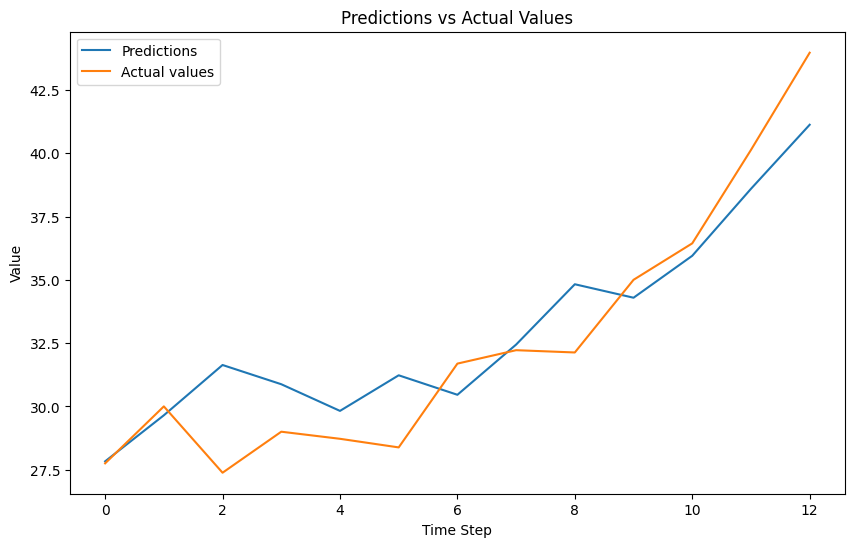

In [183]:
import matplotlib.pyplot as plt

# Assuming model is already defined and trained
inputs = [X[i:i+1].reshape(1, -1) for i in range(13)]

predictions = []

for input in inputs:
    pred = model.predict(input)
    predictions.append(pred[0])

# Apply inverse transformation to predictions
predictions_inv = scaler.inverse_transform(predictions)

print("Predictions:", predictions_inv)

# Apply inverse transformation to actual values
y_inv = scaler.inverse_transform(y[0:13])

print("Actual values:", y_inv)

# Create a plot
plt.figure(figsize=(10, 6))

plt.plot(predictions_inv, label='Predictions')
plt.plot(y_inv, label='Actual values')

plt.title('Predictions vs Actual Values')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()

plt.show()


In [184]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate the metrics
mae = mean_absolute_error(y_inv, predictions_inv)
mse = mean_squared_error(y_inv, predictions_inv)
rmse = np.sqrt(mse)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)


Mean Absolute Error: 1.5568529880849218
Mean Squared Error: 3.930946438560702
Root Mean Squared Error: 1.9826614533401061
